In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from datasets import load_dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load dataset from HuggingFace
ds = load_dataset("ketan0/test_regression_preds")
data = pd.DataFrame(ds['train'])

print("Dataset preview:")
print(data.head())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


regression_preds.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/890 [00:00<?, ? examples/s]

Dataset preview:
           0
0  10.376726
1   2.629205
2   2.227326
3  10.246503
4  13.391027


In [ ]:
lag = 3
vals = data['0'].values

X, y = [], []
for i in range(lag, len(vals)):
    X.append(vals[i - lag:i])
    y.append(vals[i])

X = np.array(X)
y = np.array(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


Training samples: 709, Validation samples: 178


In [ ]:
# This code block performs Linear, Ridge, Polynomial regressions

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

models = {}
train_losses = {}
val_losses = {}

# The Linear Regression code block
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
models['Linear'] = lr
train_losses['Linear'] = mean_squared_error(y_train, lr.predict(X_train_scaled))
val_losses['Linear'] = mean_squared_error(y_val, lr.predict(X_val_scaled))

# The Ridge Regression code block
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
models['Ridge'] = ridge
train_losses['Ridge'] = mean_squared_error(y_train, ridge.predict(X_train_scaled))
val_losses['Ridge'] = mean_squared_error(y_val, ridge.predict(X_val_scaled))

# The Polynomial Regression (deg 2, 4, 10) code block
for deg in [2, 4, 10]:
    poly = PolynomialFeatures(degree=deg)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)

    poly_lr = LinearRegression()
    poly_lr.fit(X_train_poly, y_train)

    models[f'Poly {deg}'] = poly_lr
    train_losses[f'Poly {deg}'] = mean_squared_error(y_train, poly_lr.predict(X_train_poly))
    val_losses[f'Poly {deg}'] = mean_squared_error(y_val, poly_lr.predict(X_val_poly))

print("Training complete for all models.")


Training complete for all models.


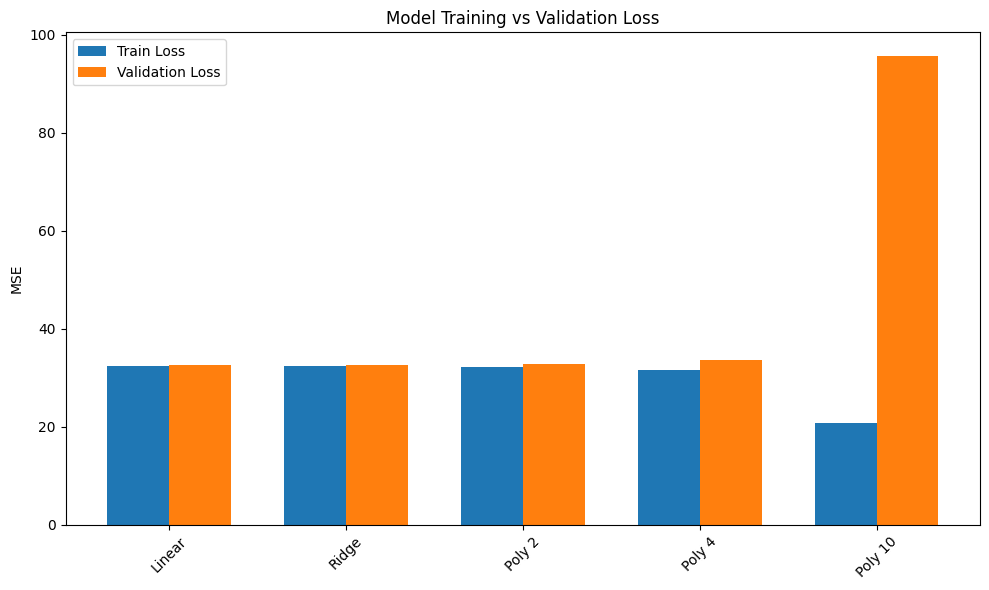

In [ ]:
# This code block plots the grouped bars for training vs validation loss
model_names = list(models.keys())
train_loss_vals = [train_losses[m] for m in model_names]
val_loss_vals = [val_losses[m] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, train_loss_vals, width=width, label='Train Loss')
plt.bar(x + width/2, val_loss_vals, width=width, label='Validation Loss')
plt.xticks(x, model_names, rotation=45)
plt.ylabel('MSE')
plt.title('Model Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# perfoms Cross-validation on best model
best_model_name = min(val_losses, key=val_losses.get)
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Prepare features accordingly
if "Poly" in best_model_name:
    degree = int(best_model_name.split()[-1])
    poly = PolynomialFeatures(degree=degree)
    X_scaled_poly = poly.fit_transform(scaler.fit_transform(X))
    model_for_cv = LinearRegression()
    scores = cross_val_score(model_for_cv, X_scaled_poly, y, scoring='neg_mean_squared_error', cv=5)
else:
    X_scaled = scaler.fit_transform(X)
    model_for_cv = best_model
    scores = cross_val_score(model_for_cv, X_scaled, y, scoring='neg_mean_squared_error', cv=5)

print(f"Cross-validation MSE: {(-scores).mean():.4f} ± {(-scores).std():.4f}")


Best model: Ridge
Cross-validation MSE: 32.6472 ± 1.8381


In [ ]:
# Using Feed forward Neural Network (FNN)
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse')

history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100, batch_size=16, verbose=0
)

# Evaluate NN
nn_train_mse = nn_model.evaluate(X_train_scaled, y_train, verbose=0)
nn_val_mse = nn_model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"Neural Network Train MSE: {nn_train_mse:.4f}")
print(f"Neural Network Validation MSE: {nn_val_mse:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network Train MSE: 31.5325
Neural Network Validation MSE: 33.1742


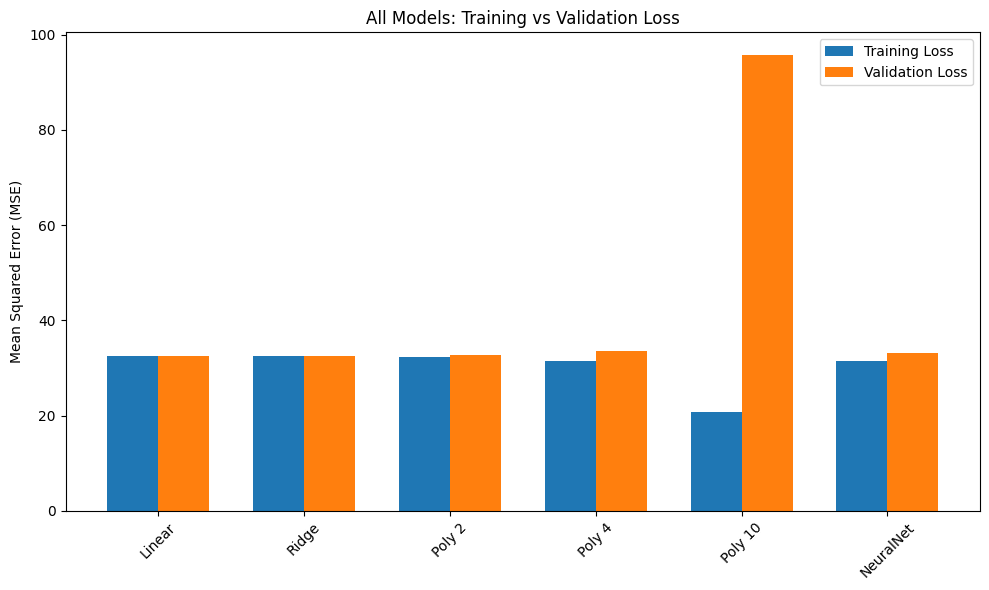

In [ ]:
# Compare all models visually (including NN, fixed version)

# Create combined loss records
model_names_full = list(models.keys()) + ["NeuralNet"]
train_loss_full = [train_losses[m] for m in models.keys()] + [nn_train_mse]
val_loss_full = [val_losses[m] for m in models.keys()] + [nn_val_mse]

# Plot
x = np.arange(len(model_names_full))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, train_loss_full, width=width, label='Training Loss')
plt.bar(x + width/2, val_loss_full, width=width, label='Validation Loss')
plt.xticks(x, model_names_full, rotation=45)
plt.ylabel('Mean Squared Error (MSE)')
plt.title('All Models: Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Conclusion Summary of the training
print("\n=== Model Performance Summary ===")

# Combine all models into one unified dictionary
all_models = {name: (train_losses[name], val_losses[name]) for name in models.keys()}
all_models["NeuralNet"] = (nn_train_mse, nn_val_mse)

# Print summary neatly
for m, (train_mse, val_mse) in all_models.items():
    print(f"{m:25s} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

# Determine best model (lowest validation loss)
best_model_name = min(all_models, key=lambda x: all_models[x][1])

print("\n=== Conclusion ===")
print(f"Best classical model (lowest val loss): {best_model_name}")
print("The Neural Network may perform similarly or slightly better if enough epochs and tuning are applied.\n"
      "If Ridge or Polynomial(2) outperforms Linear, it suggests the data has mild non-linearity.\n"
      "Surprisingly low MSEs may indicate an easy-to-predict or smooth series, not overfitting.")


=== Model Performance Summary ===
Linear                    | Train MSE: 32.488162 | Val MSE: 32.538825
Ridge                     | Train MSE: 32.488163 | Val MSE: 32.538599
Poly 2                    | Train MSE: 32.273056 | Val MSE: 32.802706
Poly 4                    | Train MSE: 31.532866 | Val MSE: 33.551751
Poly 10                   | Train MSE: 20.816933 | Val MSE: 95.714981
NeuralNet                 | Train MSE: 31.532511 | Val MSE: 33.174206

=== Conclusion ===
Best classical model (lowest val loss): Ridge
The Neural Network may perform similarly or slightly better if enough epochs and tuning are applied.
If Ridge or Polynomial(2) outperforms Linear, it suggests the data has mild non-linearity.
Surprisingly low MSEs may indicate an easy-to-predict or smooth series, not overfitting.
